In [2]:
from pyspark.sql.functions import col, unix_timestamp, from_unixtime
from pyspark.sql import functions as F
from pyspark import SparkFiles

# let's begin by creating the spark context
# we can reuse this later
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local) created by __init__ at /tmp/ipykernel_5016/224619401.py:9 

+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------------------------+---------+---------------+-------------+-----+----------------------+----------------+------------+-----------+
|      ID|Case Number|                Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|Historical Wards 2003-2015|Zip Codes|Community Areas|Census Tracts|Wards|Boundaries - ZIP Codes|Police Districts|Police Beats|Wards 2023-|
+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+----

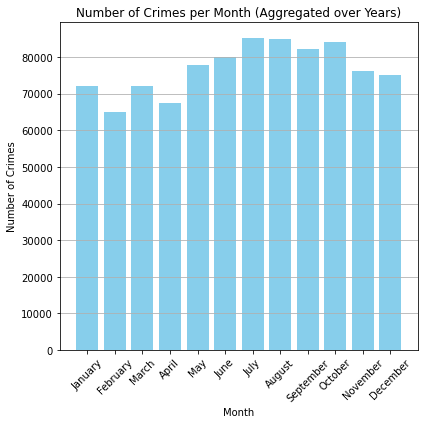

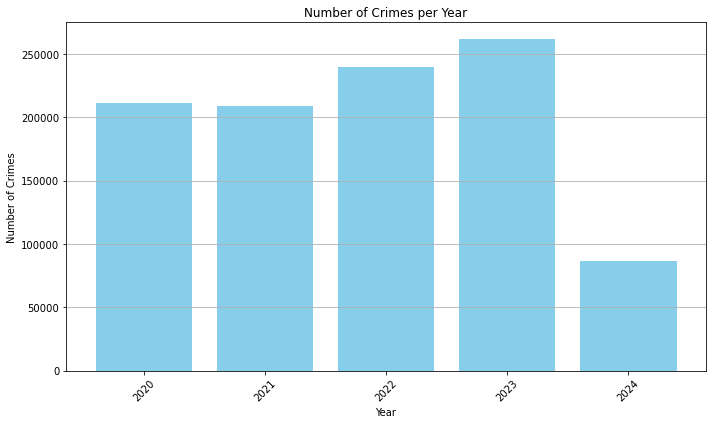

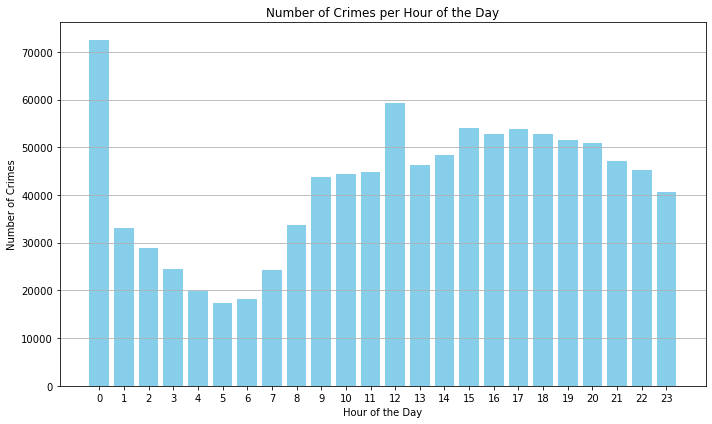

In [4]:
import matplotlib.pyplot as plt

# load csv
# gotta switch between 2020 and 2001 onwards depending on what we're calculating
data = spark.read.csv('crimes_2020_onwards.csv', header=True, inferSchema=True)
# data = spark.read.csv('crimes_2001_onwards.csv', header=True, inferSchema=True)

# let's check the original data first
data.show(5)

# remove most columns that we don't really need for the upcoming analysis
columns_to_keep = ["Date", "Primary Type", "Year", "Latitude", "Longitude"]
data = data.select(columns_to_keep)

# parse date to years, months and hours
data = data.withColumn('Date', F.to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a'))
data = data.withColumn('Month', F.month('Date'))
data = data.withColumn('Year', F.year('Date'))
data = data.withColumn('Hour', F.hour('Date'))

### PLOT 1

# remove 2024 because the year is incomplete and would bias the results
data_until2024 = data.filter(F.year('Date') != 2024)

# group by month and count occurrences
crimes_per_month = data_until2024.groupBy('Month').count().orderBy('Month')

# let's see if the dataset has been wrangled correctly
data.show(5)

# create plot
crimes_per_month_pd = crimes_per_month.toPandas()
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.figure(figsize=(6, 6))
plt.bar(crimes_per_month_pd['Month'], crimes_per_month_pd['count'], color='skyblue')
plt.title('Number of Crimes per Month (Aggregated over Years)')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(range(1, 13), months, rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### PLOT 2

crimes_per_year = data.groupBy('Year').count().orderBy('Year')
crimes_per_year_pd = crimes_per_year.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(crimes_per_year_pd['Year'], crimes_per_year_pd['count'], color='skyblue')
plt.title('Number of Crimes per Year')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.xticks(crimes_per_year_pd['Year'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### PLOT 3

crimes_per_hour = data.groupBy('Hour').count().orderBy('Hour')
crimes_per_hour_pd = crimes_per_hour.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(crimes_per_hour_pd['Hour'], crimes_per_hour_pd['count'], color='skyblue')
plt.title('Number of Crimes per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(24), range(24))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

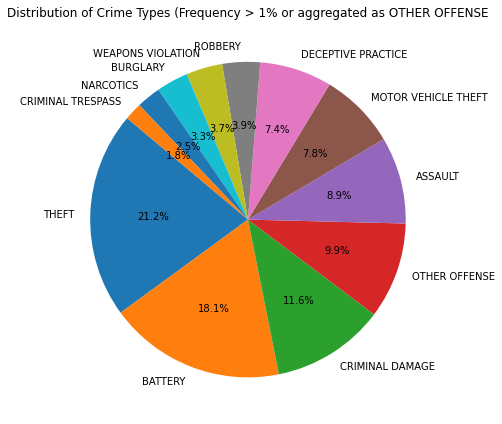

In [5]:
import matplotlib.pyplot as plt

# get counts of primary types
crime_type_counts = data.groupBy('Primary Type').count()

# get total counts
total_crimes = crime_type_counts.agg(F.sum('count')).collect()[0][0]

# reclassify the other offenses ( < 1% )
threshold_count = total_crimes * 0.01
insignificant_crime_types = crime_type_counts.filter(crime_type_counts['count'] < threshold_count)
data = data.withColumn('Primary Type', 
                       F.when(data['Primary Type'].isin([row['Primary Type'] for row in insignificant_crime_types.collect()]), 
                              F.lit("OTHER OFFENSE")).otherwise(data['Primary Type']))

# make the slices in descending order of size
crime_type_counts = data.groupBy('Primary Type').count().orderBy('count', ascending=False)

# make the plot
crime_type_pd = crime_type_counts.toPandas()
plt.figure(figsize=(10, 6))
plt.pie(crime_type_pd['count'], labels=crime_type_pd['Primary Type'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Crime Types (Frequency > 1% or aggregated as OTHER OFFENSE')
plt.tight_layout()
plt.show()


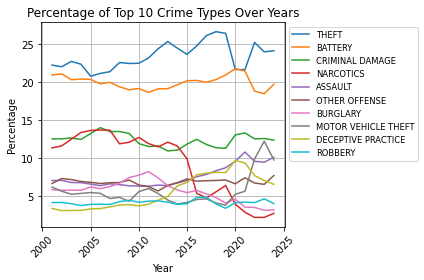

In [12]:
# group by year and type
crime_type_per_year = data.groupBy('Year', 'Primary Type').count()

# filter for top 10 types over all the years
top_10_types = crime_type_per_year.groupBy('Primary Type').agg(F.sum('count').alias('total_count')) \
                                  .orderBy('total_count', ascending=False).limit(10).select('Primary Type').rdd.flatMap(lambda x: x).collect()
crime_type_per_year = crime_type_per_year.filter(crime_type_per_year['Primary Type'].isin(top_10_types))

# pivot the data
crime_type_per_year = crime_type_per_year.groupBy('Year').pivot('Primary Type').sum('count').fillna(0)

# get percentages
crime_type_per_year = crime_type_per_year.withColumn("total", sum(F.col(c) for c in crime_type_per_year_pivot.columns[1:]))
for col in top_10_types:
    crime_type_per_year = crime_type_per_year.withColumn(col, (F.col(col) / F.col("total")) * 100)


# make plot
crime_type_per_year_pivot_pd = crime_type_per_year.orderBy('Year').toPandas()
plt.figure(figsize=(6, 4))
for col in top_10_types:
    plt.plot(crime_type_per_year_pivot_pd['Year'], crime_type_per_year_pivot_pd[col], label=col)
plt.title('Percentage of Top 10 Crime Types Over Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()